In [30]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import scipy.stats as stats
import pandas as pd
import os
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
HOME = os.path.join(os.path.dirname(os.getcwd()), 'results/single_model_profs_new_metrics')
print HOME

/Users/cusgadmin/Desktop/plots-model-comp-paper/results/single_model_profs_new_metrics


In [72]:
import unicodedata
        
def cache_extractions(FN, more_info=False):
    with open(FN) as json_data:
        d = json.load(json_data)
    all_metrics = d["client_metrics"][0]["all_metrics"]
    result = {}
    for i in range(len(all_metrics)):
        data_lists = all_metrics[i]["metrics"]["data_lists"]
        for item in data_lists:
            key = item.keys()[0]
            key = unicodedata.normalize('NFKD', key).encode('ascii','ignore')
            if result.get(key) == None:
                result[key] = []
            data = item[key]["items"]
            data = { k: v for d in data for k, v in d.items() } # consolidate list of dicts
            value = np.concatenate([np.transpose([data.keys()]), np.transpose([data.values()])], axis = 1).astype(float)
            result[key].append(value)
    batch_sizes = d["client_metrics"][0]["mean_batch_sizes"]
    for key, value in result.iteritems():
        result[key] = np.concatenate(value)
    str_lats = d["client_metrics"][0]["all_lats"]
    import ast
    lats = [ast.literal_eval(x) for x in str_lats]
    hollistic_data = {}
    hollistic_data["e2e_lats"] = np.asarray(lats).flatten()
    hollistic_data["p99_lats"] = d["client_metrics"][0]["p99_lats"]
    hollistic_data["e2e_thrus"] = d["client_metrics"][0]["thrus"]
    mean_batch_sizes = d["client_metrics"][0]["mean_batch_sizes"]
    mean_batchsizes_final = {}
    for dictionary in mean_batch_sizes:
        keys_a = set(dictionary.keys())
        keys_b = set(mean_batchsizes_final.keys())
        intersection = keys_a & keys_b
        just_in_dictionary = keys_a - keys_b
        for key in intersection:
            mean_batchsizes_final[key].append(dictionary[key])
        for key in just_in_dictionary:
            mean_batchsizes_final[key] = [dictionary[key]]
    hollistic_data["mean_batch_sizes"] = mean_batchsizes_final
    if more_info:
        used_delay = d["client_metrics"][0]["used_delay"].split("|")
        hollistic_data["used_delay_process"] = used_delay[0]
        hollistic_data["used_delay_batchsize"] = used_delay[1]
        hollistic_data["used_delay_value"] = used_delay[2]
        import re
        client_timestamps = {}
        for k,v in d["client_metrics"][0].iteritems():
            if re.compile(".+->.+_timestamps").match(k):
                client_timestamps[str(k)] = np.asarray(v)  
        hollistic_data["client_timestamps"] = client_timestamps

    return result, hollistic_data

resnet_models = [
    "tf-resnet-feats"
]

ksvm_models = [
    "tf-kernel-svm"
]

logreg_models = [
    "tf-log-reg"
]

resnet1, resnet_hollistic1 = cache_extractions(HOME+"/"+"results-180315_220518.json", more_info=True)
resnet2, resnet_hollistic2 = cache_extractions(HOME+"/"+"results-180315_223719.json", more_info=True)



def clean_and_remove_quarter(cache_extraction):
    # taking off the first 25% of the records to be sure the warmup time is removed
    for key, value in cache_extraction.iteritems():
        sorted_timestamps = np.argsort(value[:,0])
        value = value[sorted_timestamps] # sort data by timestamps
        cache_extraction[key] = value[value.shape[0]/20:] # cut off the first fourth from warmup effects

clean_and_remove_quarter(resnet2)
clean_and_remove_quarter(resnet1)
    
for key, value in resnet2.iteritems():
    print key, value.shape

rpc propagation latencies list - THREADPOOL END (18816, 2)
rpc propagation latencies list - THREADPOOL BEGINNING (4807, 2)
model:tf-resnet-feats:1:prediction_latencies_list (4807, 2)
tf-resnet-feats:1:queue_sizes (23636, 2)
tf-resnet-feats:processing_latency (4806, 2)
tf-resnet-feats:1:processing_outs (11799, 2)
tf-resnet-feats:1:queue_arrivals (18834, 2)
app:tf-resnet-feats:prediction_latencies (18417, 2)


In [61]:
import seaborn as sns

def smoothLineHistogram(data, rug=False, label=None):
    sns.distplot(data, rug=rug, label=label)

def lineHistogram(data, label=None):
    y,binEdges=np.histogram(data)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    plt.plot(bincenters,y,'-', label=label)
    
def compare_latency_dists(cached_extractions, model_list):
    plt.figure(figsize=(5*len(model_list),5))
    for i, model in enumerate(model_list):
        plt.subplot(1, len(model_list), i+1)
        plt.title(model+" Processing Latency")
        plt.xlabel("Time (ms)")
        plt.ylabel("Frequency")
        processing_time = cached_extractions[model+":processing_latency"][:,1]
        serving_time = cached_extractions["app:"+model+":prediction_latencies"][:,1]
        serving_time = serving_time/1000. # converting to ms
        smoothLineHistogram(processing_time, label="Processing time")
        smoothLineHistogram(serving_time, label="Processing + Queueing time")
    plt.legend()

def compare_latency_dists_over_time(cached_extractions, model_list):
    plt.figure(figsize=(20, 5*len(model_list)))
    for i, model in enumerate(model_list):
        ax = plt.subplot(len(model_list), 1, i+1)
        processing_time = cached_extractions[model+":processing_latency"][:,1]
        processing_time_timestamps = cached_extractions[model+":processing_latency"][:,0]
        serving_time = cached_extractions["app:"+model+":prediction_latencies"][:,1]
        serving_time = serving_time/1000. # converting to ms
        serving_time_timestamps = cached_extractions["app:"+model+":prediction_latencies"][:,0]
        plt.title(model+" Processing Latency")
        plt.xlabel("timestamp since begining of experiment)")
        plt.ylabel("Latency (ms)")
        needlog = True #np.max(intervals) - np.min(intervals) > 10
        bounds = np.asarray([min(np.min(processing_time),np.min(serving_time)), max(np.max(processing_time),np.max(serving_time))])
        if needlog:
            plt.yscale('symlog')
            from matplotlib.ticker import SymmetricalLogLocator
            ax.yaxis.set_major_locator(SymmetricalLogLocator(linthresh = 1, base=10.0, subs=np.arange(10)))
        ax.grid()
        plt.scatter(processing_time_timestamps, processing_time, alpha = 0.15, label="processing")
        plt.scatter(serving_time_timestamps, serving_time, alpha = 0.15, label="serving")
        plt.legend()

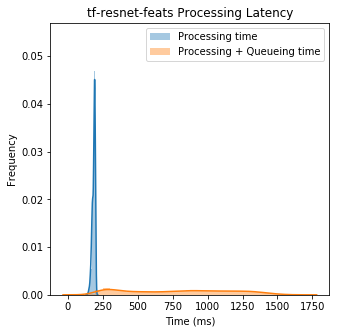

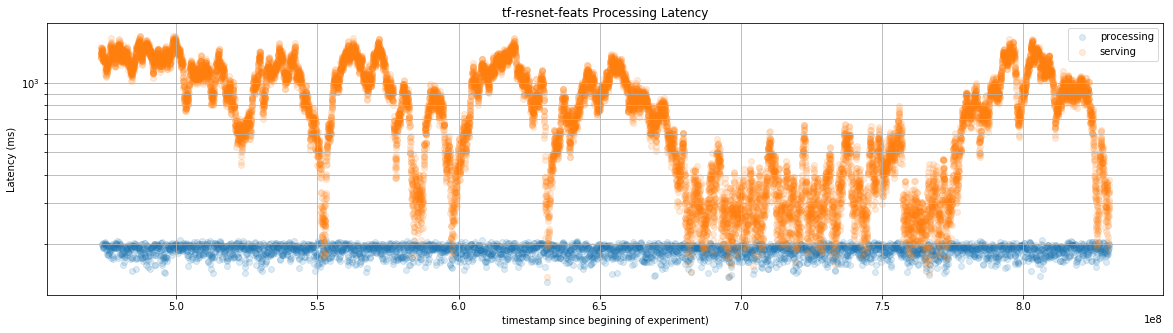

In [67]:
compare_latency_dists(resnet1, resnet_models)
compare_latency_dists_over_time(resnet1, resnet_models)

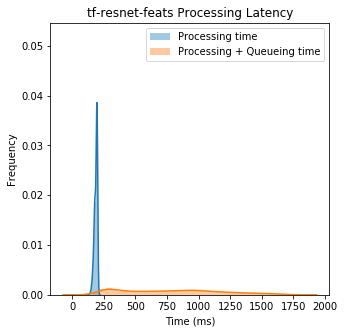

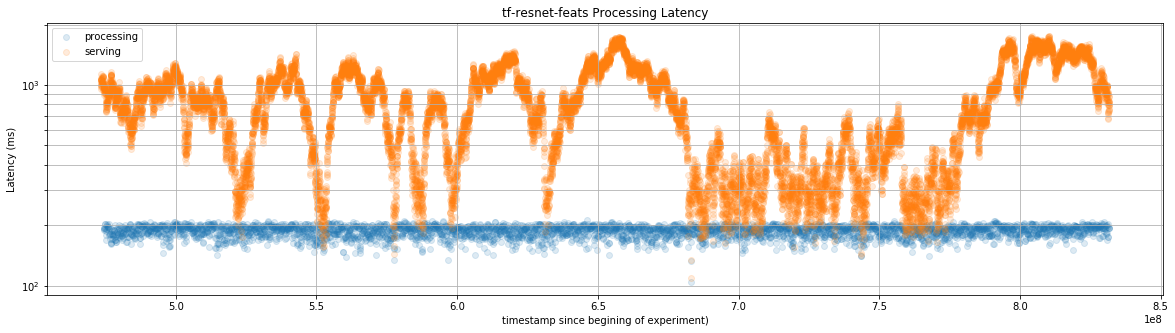

In [68]:
compare_latency_dists(resnet2, resnet_models)
compare_latency_dists_over_time(resnet2, resnet_models)

In [692]:
def get_arrival_intervals(cached_extractions, model):
    arrivals = cached_extractions[model+":1:queue_arrivals"][:,1]
    timestamps = cached_extractions[model+":1:queue_arrivals"][:,0]
    timestamps = timestamps[1:] # taking the timestamp at arrival
    intervals = arrivals[1:] - arrivals[:-1]
    intervals = intervals/1000 # to ms
    return intervals, timestamps
    
def get_outs_intervals(cached_extractions, model):
    outs = cached_extractions[model+":1:processing_outs"][:,1]
    timestamps = cached_extractions[model+":1:processing_outs"][:,0]
    timestamps = timestamps[1:] # taking the timestamp at arrival
    intervals = outs[1:] - outs[:-1]
    intervals = intervals/1000 # to ms
    return intervals, timestamps

def plot_inter_arrival(cached_extractions, model_list):
    plt.figure(figsize=(8,8))
    plt.title("Inter-arrival time")
    plt.xlabel("Inter-arrival time (ms)")
    plt.ylabel("Frequency")
    for model in model_list:
        arrival_intervals, _ = get_arrival_intervals(cached_extractions, model)
        outs_intervals, _ = get_outs_intervals(cached_extractions, model)
        arrival_CV = np.square(np.std(arrival_intervals)/np.mean(arrival_intervals))
        outs_CV = np.square(np.std(outs_intervals)/np.mean(outs_intervals))
        plt.axvline(x=np.mean(arrival_intervals), color="blue")
        plt.axvline(x=np.mean(outs_intervals), color="orange")
        smoothLineHistogram(arrival_intervals, label=model+str(" arrival CV="+str(arrival_CV)))
        smoothLineHistogram(outs_intervals, label=model+str(" outs CV="+str(outs_CV)))
    plt.legend()
    plt.show()

def plot_inter_arrival_over_time(cached_extractions, model_list):
    plt.figure(figsize=(20, 5*len(model_list)))
    for i, model in enumerate(model_list):
        ax = plt.subplot(len(model_list), 1, i+1)
        arrival_intervals, arrival_timestamps = get_arrival_intervals(cached_extractions, model)
        arrival_CV = np.square(np.std(arrival_intervals)/np.mean(arrival_intervals))
        outs_intervals, outs_timestamps = get_outs_intervals(cached_extractions, model)
        outs_CV = np.square(np.std(outs_intervals)/np.mean(outs_intervals))
        plt.title(model+" Inter-arrival time")
        plt.xlabel("Position")
        plt.ylabel("Inter-arrival time (ms)")
        needlog = True #np.max(intervals) - np.min(intervals) > 10
        bounds = np.asarray([min(np.min(arrival_intervals),np.min(outs_intervals)), max(np.max(arrival_intervals),np.max(outs_intervals))])
        if needlog:
            plt.yscale('symlog')
            from matplotlib.ticker import SymmetricalLogLocator
            ax.yaxis.set_major_locator(SymmetricalLogLocator(linthresh = 1, base=10.0, subs=np.arange(10)))
        ax.grid()
        print len(arrival_intervals), len(outs_intervals)
        plt.scatter(arrival_timestamps, arrival_intervals, label="arrival CV="+str(arrival_CV), alpha = 0.3)
        plt.scatter(outs_timestamps, outs_intervals, label="outs CV="+str(outs_CV), alpha = 0.3)
        plt.axhline(y=np.mean(arrival_intervals), color="blue", linestyle="--")
        plt.axhline(y=np.mean(outs_intervals), color="orange", linestyle="--")
        plt.legend()
    plt.show()


In [ ]:
plot_inter_arrival_over_time(resnet4_exp, resnet_models)
plot_inter_arrival(resnet4_exp, resnet_models)

In [81]:
def plot_queue_sizes(cached_extractions, model_list, log=False):
    plt.figure(figsize=(8,8))
    plt.title("Queue length")
    plt.xlabel("Length")
    plt.ylabel("Frequency")
    if log:
        plt.xscale("log")
    for model in model_list:
        sizes = cached_extractions[model+":1:queue_sizes"]
        plt.hist(sizes, label=model,alpha=0.3)
    plt.legend()
    
def plot_ordinal_queue_sizes(cached_extractions, model_list):
    plt.figure(figsize=(20, 5*len(model_list)))
    for i, model in enumerate(model_list):
        ax = plt.subplot(len(model_list), 1, i+1)
        sizes = cached_extractions[model+":1:queue_sizes"][:,1]
        timestamps = cached_extractions[model+":1:queue_sizes"][:,0]/1000000.
        plt.title(model+" Queue length")
        plt.xlabel("Position")
        plt.ylabel("Length")
        needlog = np.max(sizes) - np.min(sizes) > 10
        bounds = np.asarray([np.min(sizes), np.max(sizes)])
        if needlog:
            plt.yscale('symlog')
            from matplotlib.ticker import SymmetricalLogLocator
            ax.yaxis.set_major_locator(SymmetricalLogLocator(linthresh = 1, base=10.0, subs=np.arange(10)))
        ax.grid()
        plt.scatter(timestamps, sizes, label=model, alpha = 0.3)

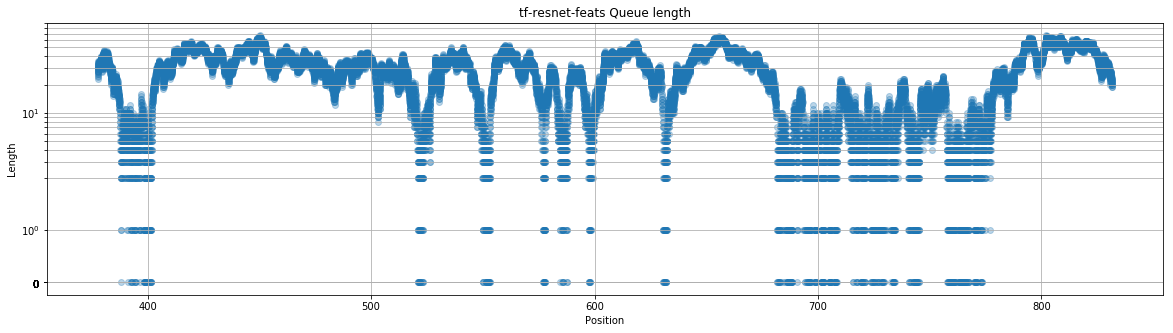

In [82]:
plot_ordinal_queue_sizes(resnet2, resnet_models)

In [83]:
def plot_e2e_lats(cached_extractions):
    plt.figure(figsize=(8,8))
    plt.title("e2e Latencies")
    lats = cached_extractions["e2e_lats"]
    plt.plot(np.arange(len(lats)), lats)
    plt.xlabel("Experiment iteration")
    plt.axhline(y=0.5, color='r', linestyle='--', label="500ms SLO")
    plt.legend()
    plt.ylabel("Latency (ms)")

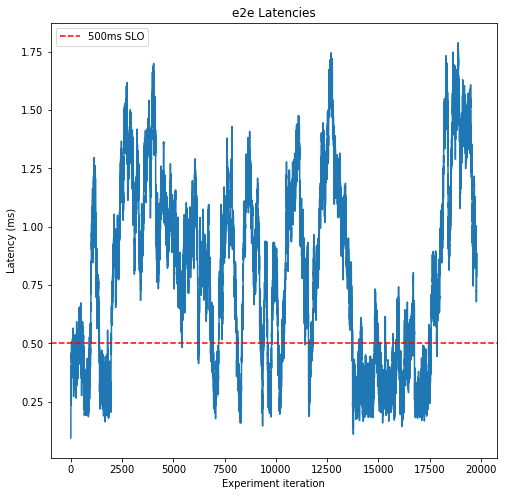

In [86]:
plot_e2e_lats(resnet_hollistic2)

In [47]:
def plot_e2e_thrus(cached_extractions):
    plt.figure(figsize=(8,8))
    plt.title("e2e Throughputs")
    thrus = cached_extractions["e2e_thrus"]
    plt.scatter(np.arange(len(thrus)), thrus)
    plt.xlabel("Experiment iteration")
    plt.ylabel("Throughput (queries per second)")
    label = cached_extractions["used_delay_process"] + cached_extractions["used_delay_batchsize"]
    plt.axhline(y=1/float(cached_extractions["used_delay_value"]), color="red", linestyle='--', label=label)
    plt.grid(True)
    plt.legend()

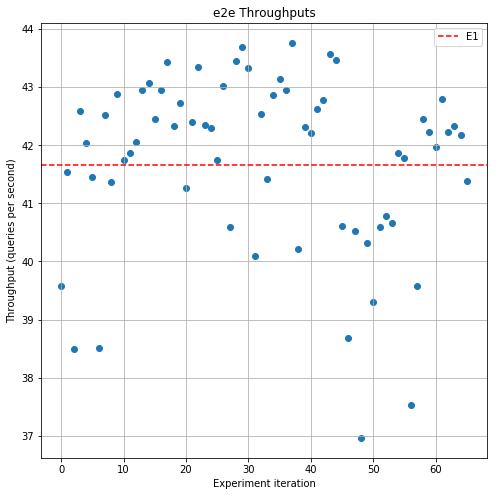

In [85]:
plot_e2e_thrus(resnet_hollistic2)

In [50]:
def plot_mean_effective_batchsizes(cached_extraction):
    plt.figure(figsize=(8,8))
    plt.title("Mean effective batchsizes")
    batchsizes = cached_extraction["mean_batch_sizes"]
    for key in batchsizes.keys():
        plt.scatter(np.arange(len(batchsizes[key])), batchsizes[key], label=key)
    plt.xlabel("Experiment iteration")
    plt.ylabel("Mean effective batchsize")
    plt.legend()
    plt.grid(True)


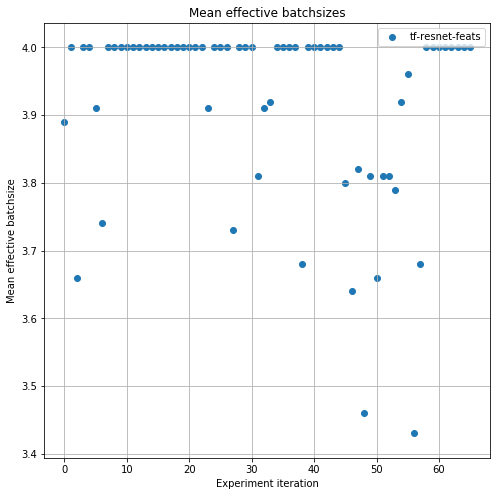

In [87]:
plot_mean_effective_batchsizes(resnet_hollistic2)